In [13]:
import os
import re
## 本算法使用CPU训练
## 此条命令运行必须放在 import torch 之前，否则不能生效
# os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
import sys
### pytorch 相关
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
### pytorch 自定义损失函数
from torch.autograd import Function
from torch.autograd import Variable

### torchvision
import torchvision.transforms as transforms

import quaternion # qw qx qy qz

### matplotlib
from matplotlib import pyplot as plt

### numpy
import numpy as np

### time，延时函数-秒 time.sleep(1) 延时1秒
import time 

### PIL
from PIL import Image

### SciPy
import scipy.signal as signal
from scipy.spatial.transform import Rotation
from scipy.signal import butter, lfilter, freqz

### SciPy
import scipy.signal as signal

# jupyter 使用 matplotlib 绘图所需，否则会挂掉
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# 数据集相关
from torch.utils.data import Dataset, DataLoader

# 配置文件读取 yaml
import yaml

# 进度条
import tqdm

# 命令行
import subprocess

import datetime

# 统计模型参数量
from torchsummary import summary

from tinyGC2L import TinyGC2L_Net

## Readme

To use the retrained network weight file, please modify the variable "weight_dir" to: " 'weights/weights_400_samples/400_total' "


In [14]:
### 全局变量
device = torch.device('cpu') 

# 'weights/weights_400_samples/400_total'  
weight_dir = 'weights/weights_400_samples_test/400_total'  

# 数据集名称
data_sets = ['MH_02_easy', 'MH_04_difficult',
             'V1_01_easy', 'V1_03_difficult', 
             'V2_02_medium']
# data_sets = ['V1_03_difficult']

# 加载已训练好的模型
currentPath = os.getcwd()    # 获取当前路径 /home/sjtu/workspace/LWGC/code
project_path = os.path.abspath(os.path.join(currentPath, "..")) # /home/sjtu/workspace/LWGC
config_path = os.path.join(project_path, "configs", "euroc_const_bias.yaml")

model_path = os.path.join(project_path, weight_dir) + '/best-model.pth'
assert os.path.exists(model_path)

print(model_path)


/home/cc/TinyGC-Net/weights/weights_400_samples/400_total/best-model.pth


In [15]:
def quaternion_multiply(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2

    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2
    z = w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2

    return np.array([w, x, y, z])

def normalize_quaternion(quaternion):
    norm = np.linalg.norm(quaternion)
    normalized_quaternion = quaternion / norm
    return normalized_quaternion


def integrate_quat(timestamps, gyro_set, start_quat):
    inte_quat = np.array([])
    inte_quat = np.append(inte_quat, start_quat)
    
    for idx in range(len(timestamps) - 1):
        tmp_gyro = (gyro_set[idx] + gyro_set[idx+1])*0.5
        # 一定要注意时间戳
        dt_s = (timestamps[idx+1] - timestamps[idx]) #
        dtheta_half = tmp_gyro*dt_s*0.5
        dq = np.array([1.0, dtheta_half[0], dtheta_half[1], dtheta_half[2]])
        # dq = normalize_quaternion(dq)
        start_quat = quaternion_multiply(start_quat, dq)
        start_quat = normalize_quaternion(start_quat)
        # 

        inte_quat = np.append(inte_quat, start_quat)
    inte_quat.resize((len(inte_quat)//4,4))
    return inte_quat

# scipy中四元数顺序为 scalar-last (x, y, z, w) format
# matlab中四元数为 scalar-first (w, x, y, z) format
# Eigen::Quaterniond q1(w, x, y, z);// 第一种方式
# Eigen::Quaterniond q2(Vector4d(x, y, z, w));// 第二种方式
# input quat: scalar-first (w, x, y, z)
def quat_to_euler_deg(quat):
    roll_deg = np.array([])
    pitch_deg = np.array([])
    yaw_deg = np.array([])

    for i in range(len(quat)):
        rotm = Rotation.from_quat([quat[i, 1], quat[i, 2], quat[i, 3], quat[i, 0]])
        euler_angles = rotm.as_euler('ZYX', degrees = True)
        roll_deg = np.append(roll_deg, euler_angles[2])
        pitch_deg = np.append(pitch_deg, euler_angles[1])
        yaw_deg = np.append(yaw_deg, euler_angles[0])
    
    return roll_deg, pitch_deg, yaw_deg

# the returned quat: scalar-first (w, x, y, z)
def euler_deg_to_quat(roll_deg, pitch_deg, yaw_deg):
    quat = np.array([])
    for i in range(len(roll_deg)):
        rotm = Rotation.from_euler('ZYX',  [yaw_deg[i], pitch_deg[i], roll_deg[i]], degrees = True)
        quat = np.append(quat, np.expand_dims(rotm.as_quat(), axis=0))
    quat = quat.reshape(-1, 4)
    quat = quat[:, [3, 0, 1, 2]]
    return quat

In [16]:
### 数据集读取类
class Eurocdata(object):
    def __init__(self, gt_file_path, imu_file_path):
        self.gt_file_path = gt_file_path
        self.imu_file_path = imu_file_path
        self.get_gt_values()
        self.get_imu_values()
        self.timestamp_align()

    def get_gt_values(self):
        with open(self.gt_file_path, 'r', encoding = 'utf-8') as file_gt:
            data = np.loadtxt(file_gt, delimiter=',', skiprows=0)
        self.gt_timestamp = data[:,0] * 1e-9 # 将 时间戳的单位由纳秒转为秒
        self.gt_qw = data[:,4]
        self.gt_qx = data[:,5]
        self.gt_qy = data[:,6]
        self.gt_qz = data[:,7]


    def get_imu_values(self):
        with open(self.imu_file_path, 'r', encoding = 'utf-8') as file_imu_raw:
                    data = np.loadtxt(file_imu_raw, delimiter=',', skiprows=0)
        self.imu_raw_timestamp = data[:,0] * 1e-9 # 将 时间戳的单位由纳秒转为秒
        self.imu_raw_wx = data[:,1]
        self.imu_raw_wy = data[:,2]
        self.imu_raw_wz = data[:,3]

        self.imu_raw_ax = data[:,4]
        self.imu_raw_ay = data[:,5]
        self.imu_raw_az = data[:,6]

    def timestamp_align(self):
        ### 时间戳完全对齐，以imu时刻为基准，调整gt相对应时刻的值（线性插值）
        #### 新建空白数组 时间戳
        self.aligned_timestamp = np.array([])
        #### 新建空白数据 IMU 数据
        self.aligned_imu_wx = np.array([])
        self.aligned_imu_wy = np.array([])
        self.aligned_imu_wz = np.array([])
        self.aligned_imu_ax = np.array([])
        self.aligned_imu_ay = np.array([])
        self.aligned_imu_az = np.array([])

        self.aligned_imu_wx_rb = np.array([])
        self.aligned_imu_wy_rb = np.array([])
        self.aligned_imu_wz_rb = np.array([])

        #### 新建空白数组 姿态
        self.aligned_qw = np.array([])
        self.aligned_qx = np.array([])
        self.aligned_qy = np.array([])
        self.aligned_qz = np.array([])

        i = 0 # idx for imu, 以imu时刻为基准
        j = 0 # idx for gt

        while i < np.size(self.imu_raw_timestamp)-1 and j < np.size(self.gt_timestamp)-1:
            # imu_i = self.imu_raw_timestamp[i]
            # self.gt_j = self.gt_timestamp[j]
            # self.gt_j1 = self.gt_timestamp[j+1]
            # imu的时间戳早于gt，说明imu启动的时间早于gt，即当前的imu时刻无法获取真实位姿
            # imu_i ... --> self.gt_j
            if self.imu_raw_timestamp[i] < self.gt_timestamp[j]:
                i = i + 1
                continue
            # imu的时间戳晚于gt多次
            # self.gt_j -->  self.gt_j+1 --> ... --> imu_i
            if self.imu_raw_timestamp[i] > self.gt_timestamp[j] and self.imu_raw_timestamp[i] > self.gt_timestamp[j+1]:
                j = j + 1
                continue
            # imu的时间戳晚于gt一次
            # self.gt_j -->  imu_i --> self.gt_j+1
            if self.imu_raw_timestamp[i] >= self.gt_timestamp[j] and self.imu_raw_timestamp[i] <= self.gt_timestamp[j+1]:
                # 插值比例
                fraction = (self.imu_raw_timestamp[i] - self.gt_timestamp[j])/(self.gt_timestamp[j+1] - self.gt_timestamp[j])
                # 时间戳
                self.aligned_timestamp = np.append(self.aligned_timestamp, self.imu_raw_timestamp[i])
                # 四元数插值
                q_j = np.quaternion(self.gt_qw[j], self.gt_qx[j], self.gt_qy[j], self.gt_qz[j])
                q_j1 = np.quaternion(self.gt_qw[j+1], self.gt_qx[j+1], self.gt_qy[j+1], self.gt_qz[j+1])
                # q_i = tf.transformations.quaternion_slerp(q_j, q_j1, fraction)
                q_i = quaternion.slerp_evaluate(q_j, q_j1, fraction)
                self.aligned_qw = np.append(self.aligned_qw, q_i.w)
                self.aligned_qx = np.append(self.aligned_qx, q_i.x)
                self.aligned_qy = np.append(self.aligned_qy, q_i.y)
                self.aligned_qz = np.append(self.aligned_qz, q_i.z)
                # IMU测量数据
                self.aligned_imu_wx = np.append(self.aligned_imu_wx, self.imu_raw_wx[i])
                self.aligned_imu_wy = np.append(self.aligned_imu_wy, self.imu_raw_wy[i])
                self.aligned_imu_wz = np.append(self.aligned_imu_wz, self.imu_raw_wz[i])

                self.aligned_imu_ax = np.append(self.aligned_imu_ax, self.imu_raw_ax[i])
                self.aligned_imu_ay = np.append(self.aligned_imu_ay, self.imu_raw_ay[i])
                self.aligned_imu_az = np.append(self.aligned_imu_az, self.imu_raw_az[i])

                # 此处不对 j 进行叠加，原因：两个gt时刻间可能有多个imu测量值
                i = i + 1 


In [17]:

# 创建模型实例
model = TinyGC2L_Net(device)

# 加载训练好的权重
model.load_state_dict(torch.load(model_path))

# 设置模型为评估模式
model.eval()


TinyGC2L_Net(
  (conv1): Conv2d(1, 3, kernel_size=(1, 3), stride=(1, 1))
  (relu1): PReLU(num_parameters=1)
  (conv2): Conv2d(1, 3, kernel_size=(1, 3), stride=(1, 1))
  (relu2): PReLU(num_parameters=1)
)

torch.Size([1, 29992, 3])
MH_02_easy
APE w.r.t. rotation angle in degrees (deg)
(not aligned)

       max	0.890092
      mean	0.528589
    median	0.528401
       min	0.000000
      rmse	0.580511
       sse	10107.079092
       std	0.239972


149.95499992370605


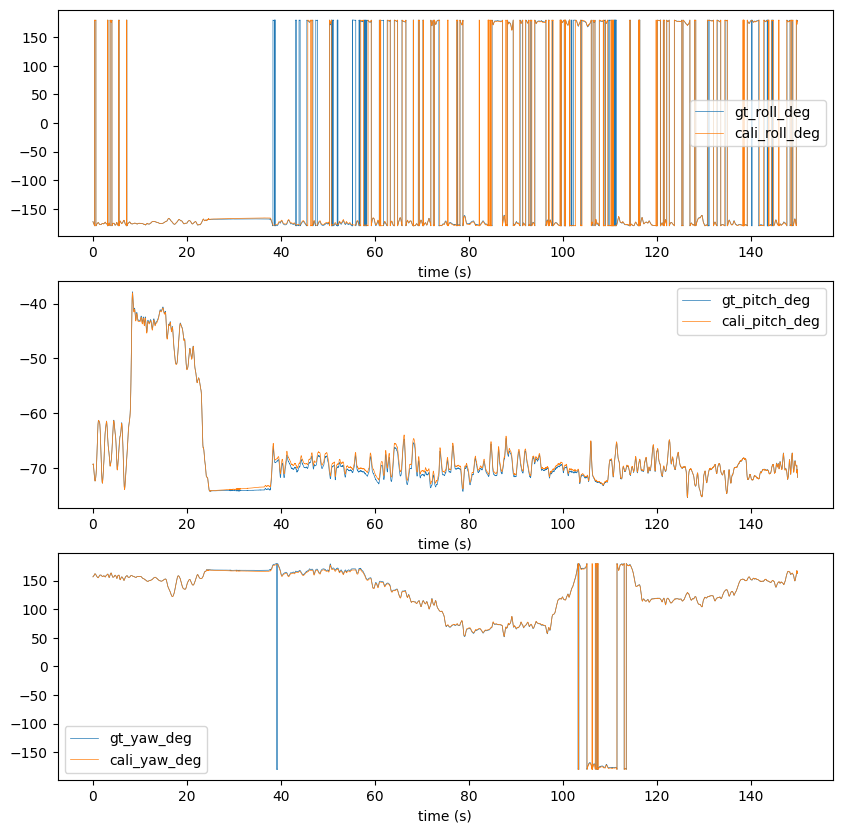

torch.Size([1, 19753, 3])
MH_04_difficult
APE w.r.t. rotation angle in degrees (deg)
(not aligned)

       max	0.985634
      mean	0.560771
    median	0.583279
       min	0.000000
      rmse	0.615005
       sse	7471.195562
       std	0.252521


98.75999999046326


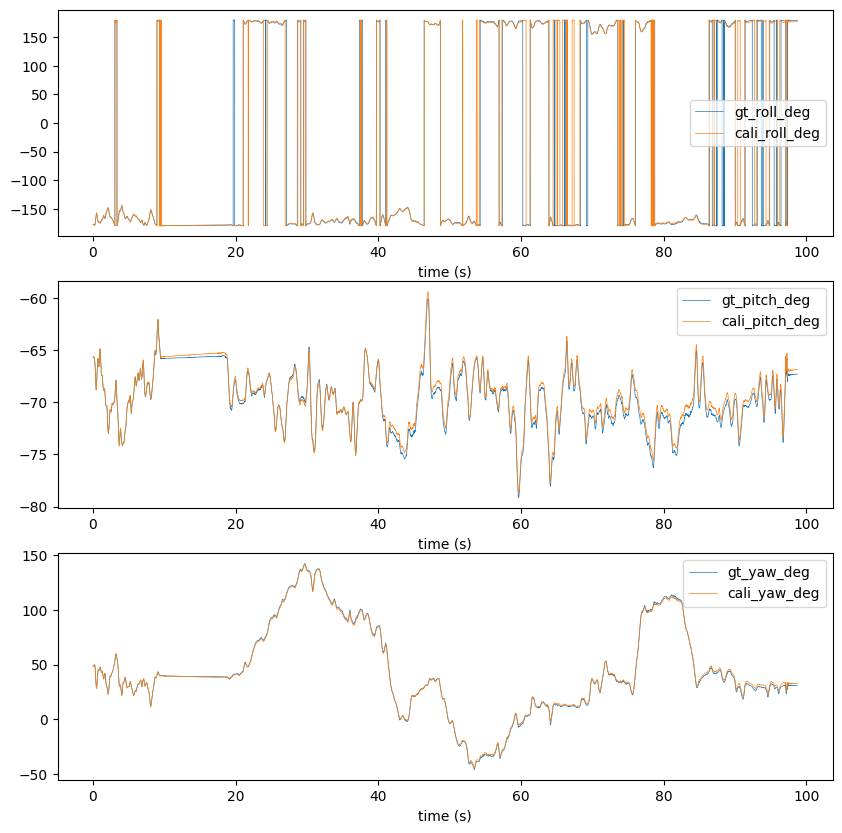

torch.Size([1, 28712, 3])
V1_01_easy
APE w.r.t. rotation angle in degrees (deg)
(not aligned)

       max	5.001865
      mean	2.064167
    median	1.650975
       min	0.000000
      rmse	2.434368
       sse	170151.570585
       std	1.290490


143.5550000667572


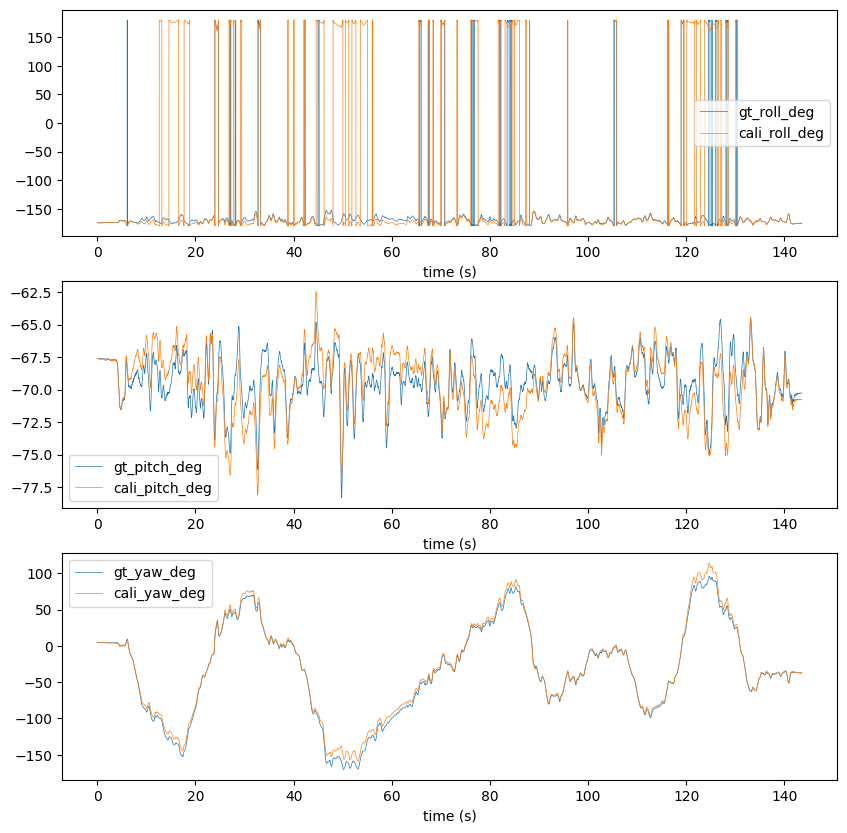

torch.Size([1, 20932, 3])
V1_03_difficult
APE w.r.t. rotation angle in degrees (deg)
(not aligned)

       max	1.796409
      mean	0.849457
    median	0.838358
       min	0.000000
      rmse	0.937400
       sse	18393.353862
       std	0.396411


104.65499997138977


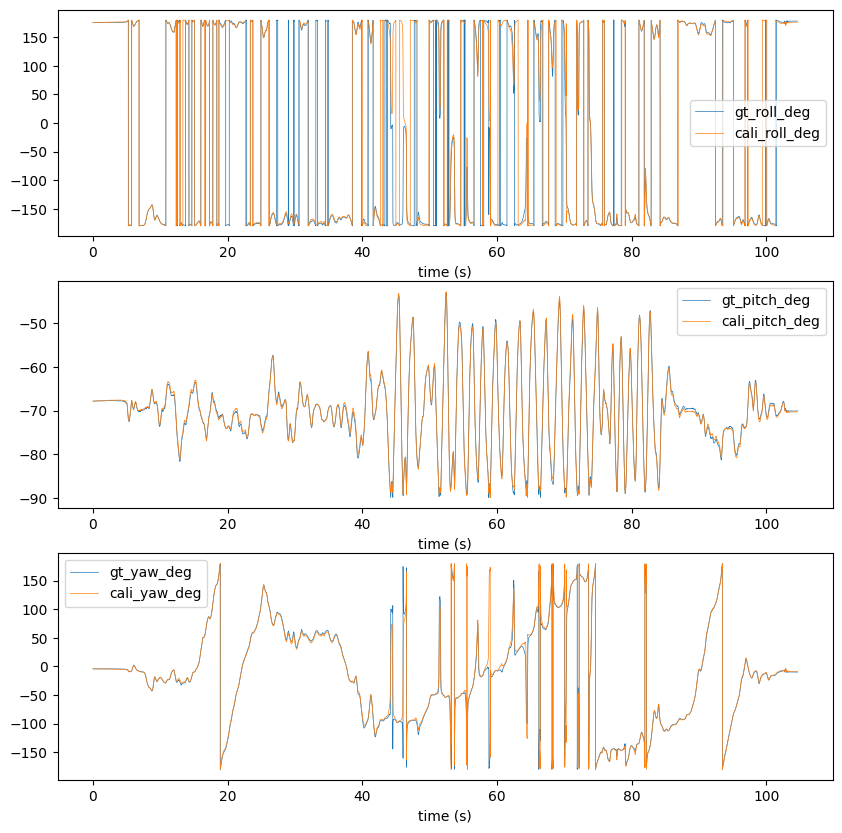

torch.Size([1, 23091, 3])
V2_02_medium
APE w.r.t. rotation angle in degrees (deg)
(not aligned)

       max	2.372623
      mean	0.869922
    median	0.717114
       min	0.000000
      rmse	1.015294
       sse	23802.726925
       std	0.523506


115.44999980926514


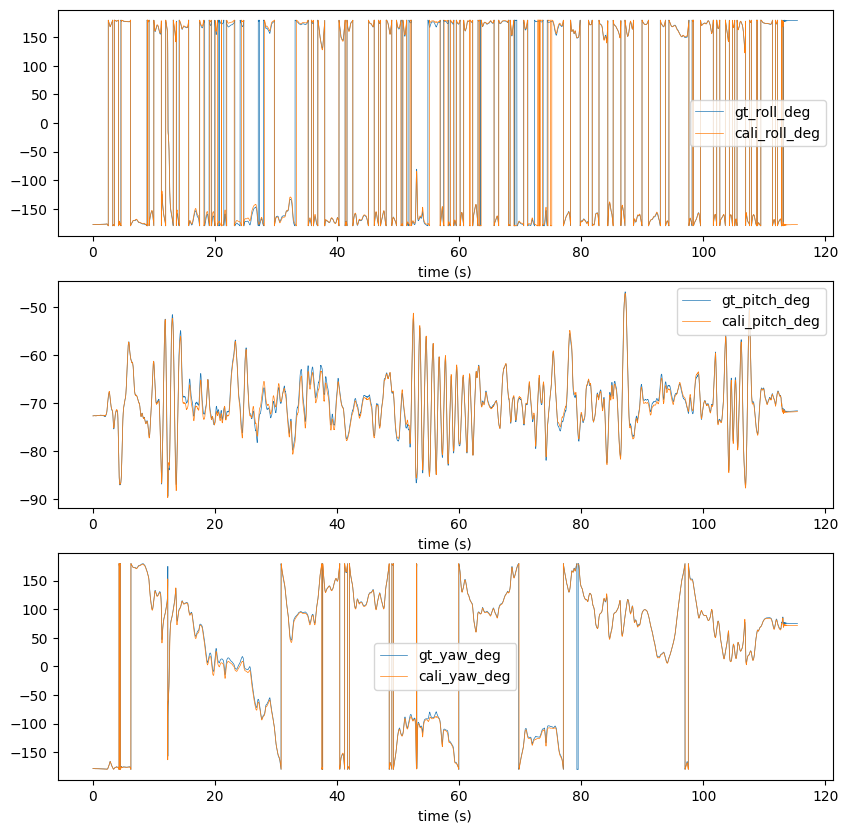

In [18]:


with open(os.path.join(project_path, weight_dir, 'evo_ape_results.txt'), 'w') as evo_ape_file:
    for data_set in data_sets:
        # 读取数据集数据
        data_path = os.path.join(project_path, 'data/Euroc', data_set)
        gt_file_path = os.path.join(data_path, 'state_groundtruth_estimate0/data.csv')
        imu_file_path = os.path.join(data_path, 'imu0/data.csv')
        # 判断几个文件是否存在
        assert os.path.isfile(gt_file_path)
        assert os.path.isfile(imu_file_path)
        euroc_data = Eurocdata(gt_file_path, imu_file_path)

        ## 减去 bias
        config_path_is_exist = os.path.exists(config_path)
        if config_path_is_exist:
            with open(config_path, 'r') as file:
                bias_config = yaml.safe_load(file)  
        else:  
            print(f"文件 {config_path} 不存在。")
        
        tmp_str1 = data_set[:data_set.rfind('_')].replace('_', '').lower()
        tmp_str2 = re.findall(r'\d+', weight_dir)[0]
        tmp_str = tmp_str2 + '_' + tmp_str1

        bias = np.array(bias_config[tmp_str])
        euroc_data.aligned_imu_wx_rb = euroc_data.aligned_imu_wx + bias[0]
        euroc_data.aligned_imu_wy_rb = euroc_data.aligned_imu_wy + bias[1]
        euroc_data.aligned_imu_wz_rb = euroc_data.aligned_imu_wz + bias[2]

        ### 基于对齐的数据对IMU数据进行积分
        # 使用四元数进行积分
        euroc_data.aligned_imu_wx_rb = euroc_data.aligned_imu_wx_rb[:, None] # 在None的位置上增加一维
        euroc_data.aligned_imu_wy_rb = euroc_data.aligned_imu_wy_rb[:, None]
        euroc_data.aligned_imu_wz_rb = euroc_data.aligned_imu_wz_rb[:, None]

        euroc_data.aligned_imu_wx = euroc_data.aligned_imu_wx[:, None] # 在None的位置上增加一维
        euroc_data.aligned_imu_wy = euroc_data.aligned_imu_wy[:, None]
        euroc_data.aligned_imu_wz = euroc_data.aligned_imu_wz[:, None]

        euroc_data.aligned_imu_ax = euroc_data.aligned_imu_ax[:, None]
        euroc_data.aligned_imu_ay = euroc_data.aligned_imu_ay[:, None]
        euroc_data.aligned_imu_az = euroc_data.aligned_imu_az[:, None]

        # 组建　gyro_set，并将其转为　tensor　形式
        # (36381, 3)   <class 'numpy.ndarray'>
        gyro_raw_set_rb = np.concatenate((euroc_data.aligned_imu_wx_rb, euroc_data.aligned_imu_wy_rb, euroc_data.aligned_imu_wz_rb), axis=1)
        gyro_raw_set = np.concatenate((euroc_data.aligned_imu_wx, euroc_data.aligned_imu_wy, euroc_data.aligned_imu_wz), axis=1)

        # 首先基于原始的陀螺仪数据进行积分，得到姿态角
        start_raw_quat = [euroc_data.aligned_qw[0], euroc_data.aligned_qx[0], euroc_data.aligned_qy[0], euroc_data.aligned_qz[0]]
        raw_quat_rb = integrate_quat(euroc_data.aligned_timestamp, gyro_raw_set_rb, start_raw_quat)
        raw_roll_rb_deg, raw_pitch_rb_deg, raw_yaw_rb_deg = quat_to_euler_deg(raw_quat_rb)

        raw_quat = integrate_quat(euroc_data.aligned_timestamp, gyro_raw_set, start_raw_quat)
        raw_roll_deg, raw_pitch_deg, raw_yaw_deg = quat_to_euler_deg(raw_quat)
        
        # # 对　IMU　进行校正，然后积分得到姿态角
        gyro_raw_set_tensor_rb = torch.from_numpy(gyro_raw_set_rb).float() # torch.Size([36381, 3])
        gyro_raw_set_tensor_rb = gyro_raw_set_tensor_rb.unsqueeze(0)
        print(gyro_raw_set_tensor_rb.shape) 
        gyro_cali_set = model.calibrate_gyro(gyro_raw_set_tensor_rb)
        gyro_cali_set = gyro_cali_set.squeeze()
        gyro_cali_set = gyro_cali_set.detach().numpy()
        # 对校正后的ＩＭＵ进行积分
        start_cali_quat = [euroc_data.aligned_qw[0], euroc_data.aligned_qx[0], euroc_data.aligned_qy[0], euroc_data.aligned_qz[0]]
        cali_time_seq = euroc_data.aligned_timestamp - euroc_data.aligned_timestamp[0]
        cali_quat = integrate_quat(
            cali_time_seq, 
            gyro_cali_set,                                                          
            start_cali_quat)
        cali_roll_deg, cali_pitch_deg, cali_yaw_deg = quat_to_euler_deg(cali_quat)

        # # 将 aligned_quat 转为欧拉角
        aligned_quat = np.concatenate((euroc_data.aligned_qw[:, np.newaxis], euroc_data.aligned_qx[:, np.newaxis], euroc_data.aligned_qy[:, np.newaxis], euroc_data.aligned_qz[:, np.newaxis]), axis = 1)
        aligned_roll_deg, aligned_pitch_deg, aligned_yaw_deg = quat_to_euler_deg(aligned_quat)
        
        # # 将gt_euler的横滚角和俯仰角置零，仅保留航向角
        # # 并将仅保留航向角的欧拉角重新转为四元数
        # # the returned quat: scalar-first (w, x, y, z)
        # aligned_quat_only_yaw = euler_deg_to_quat(np.zeros(aligned_roll_deg.shape), np.zeros(aligned_roll_deg.shape), aligned_yaw_deg)
        # cali_quat_only_yaw = euler_deg_to_quat(np.zeros(cali_yaw_deg.shape), np.zeros(cali_yaw_deg.shape), cali_yaw_deg)

        ### 汇总信息至文本中，方便进行matlab ahrs 仿真
        sim_pose_file = 'sim_pose_' + data_set + '.txt'
        with open(os.path.join(project_path, weight_dir, sim_pose_file), 'w') as file:
            for i in range(len(cali_time_seq)):
                file.write('{},{},{},{},{},{},{},{},{},{},{}\n'.format(cali_time_seq[i], 
                                                                aligned_quat[i, 0], aligned_quat[i, 1], aligned_quat[i, 2], aligned_quat[i, 3], 
                                                                gyro_cali_set[i, 0], gyro_cali_set[i, 1], gyro_cali_set[i, 2], 
                                                                euroc_data.aligned_imu_ax[i, 0], euroc_data.aligned_imu_ay[i, 0], euroc_data.aligned_imu_az[i, 0]))

        evo_timestamp = cali_time_seq                                                      

        
        ### 将数据保存为tum格式
        # tum数据集格式: timestamp tx ty tz qx qy qz qw
        gt_pose_file = 'gt_' + data_set + '.txt'
        with open(os.path.join(project_path, weight_dir, gt_pose_file), 'w') as file:
            for i in range(len(evo_timestamp)):
                file.write('{} {} {} {} {} {} {} {}\n'.format(evo_timestamp[i], 
                                                        0, 0, 0, 
                                                        euroc_data.aligned_qx[i], euroc_data.aligned_qy[i], 
                                                        euroc_data.aligned_qz[i], euroc_data.aligned_qw[i]))
        
        eval_pose_file = 'eval_' + data_set + '.txt'
        with open(os.path.join(project_path, weight_dir, eval_pose_file), 'w') as file:
            for i in range(len(evo_timestamp)):
                file.write('{} {} {} {} {} {} {} {}\n'.format(evo_timestamp[i], 
                                                        0, 0, 0, 
                                                        cali_quat[i, 1], cali_quat[i, 2], 
                                                        cali_quat[i, 3], cali_quat[i, 0]))
                # file.write('{} {} {} {} {} {} {} {}\n'.format(evo_timestamp[i], 
                #                                         0, 0, 0, 
                #                                         raw_quat_rb[i, 1], raw_quat_rb[i, 2], 
                #                                         raw_quat_rb[i, 3], raw_quat_rb[i, 0]))
        
        gt_eval_pose_file = 'gt_eval_' + data_set + '.txt'
        with open(os.path.join(project_path, weight_dir, gt_eval_pose_file), 'w') as file:
            for i in range(len(evo_timestamp)):
                file.write('{} {} {} {} {} {} {} {} {} {} {} {} {} {} {} {} {} {} {}\n'.format(evo_timestamp[i], 
                                                        euroc_data.aligned_imu_wx[i][0], euroc_data.aligned_imu_wy[i][0], euroc_data.aligned_imu_wz[i][0], 
                                                        gyro_cali_set[i,0], gyro_cali_set[i,1], gyro_cali_set[i,2], 
                                                        cali_quat[i, 1], cali_quat[i, 2],
                                                        cali_quat[i, 3], cali_quat[i, 0],
                                                        euroc_data.aligned_qx[i], euroc_data.aligned_qy[i], 
                                                        euroc_data.aligned_qz[i], euroc_data.aligned_qw[i],
                                                        raw_quat_rb[i, 1], raw_quat_rb[i, 2],
                                                        raw_quat_rb[i, 3], raw_quat_rb[i, 0]))


        gt_eval_euler_pose_file = 'gt_eval_euler_' + data_set + '.txt'
        with open(os.path.join(project_path, weight_dir, gt_eval_euler_pose_file), 'w') as file:
            for i in range(len(evo_timestamp)):
                file.write('{} {} {} {} {} {} {} {} {} {} {} {} {} {} {} {}\n'.format(evo_timestamp[i], 
                                                        euroc_data.aligned_imu_wx[i][0], euroc_data.aligned_imu_wy[i][0], euroc_data.aligned_imu_wz[i][0], 
                                                        gyro_cali_set[i,0], gyro_cali_set[i,1], gyro_cali_set[i,2], 
                                                        cali_roll_deg[i], cali_pitch_deg[i], cali_yaw_deg[i], 
                                                        aligned_roll_deg[i], aligned_pitch_deg[i], aligned_yaw_deg[i],
                                                        raw_roll_deg[i], raw_pitch_deg[i], raw_yaw_deg[i]))

        
        # 执行shell命令
        # evo_ape tum gt_V1_01_easy.txt eval_V1_01_easy.txt -r angle_deg
        result = subprocess.run(['evo_ape', 'tum', 
                                    os.path.join(project_path, weight_dir, gt_pose_file),
                                    os.path.join(project_path, weight_dir, eval_pose_file),
                                    '-r', 'angle_deg'], capture_output=True, text=True)
        
        # result_yaw_only = subprocess.run(['evo_ape', 'tum', 
        #                 os.path.join(project_path, weight_dir, gt_yaw_only_pose_file),
        #                 os.path.join(project_path, weight_dir, eval_yaw_only_pose_file),
        #                 '-r', 'angle_deg'], capture_output=True, text=True)

        print(data_set)
        print(result.stdout)
        # print(result_yaw_only.stdout)
        evo_ape_file.write(data_set)
        evo_ape_file.write(result.stdout)

        print(cali_time_seq[-1])
        
        plt.figure(100,figsize=(10,10))   # 1表示figure的唯一编号，figsize表示图片大小  plt.figure(100,figsize=(10,10), dpi=500)
        plt.subplot(3,1,1)
        plt.plot(cali_time_seq, aligned_roll_deg, linewidth=.5, label='gt_roll_deg')
        plt.plot(cali_time_seq, cali_roll_deg, linewidth=.5, label='cali_roll_deg')
        plt.xlabel('time (s)')
        plt.legend()
        plt.subplot(3,1,2)
        plt.plot(cali_time_seq, aligned_pitch_deg, linewidth=.5, label='gt_pitch_deg')
        plt.plot(cali_time_seq, cali_pitch_deg, linewidth=.5, label='cali_pitch_deg')
        plt.xlabel('time (s)')
        plt.legend()
        plt.subplot(3,1,3)
        plt.plot(cali_time_seq, aligned_yaw_deg, linewidth=.5, label='gt_yaw_deg')
        plt.plot(cali_time_seq, cali_yaw_deg, linewidth=.5, label='cali_yaw_deg')
        plt.xlabel('time (s)')
        plt.legend()
        plt.show()

        print('=========================================')
        


            